In [4]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import os, sys
import re
import pickle
import vector
import mplhep as hep
import math
from tabulate import tabulate

vector.register_awkward()

# parameters for matplotlib styling
plt.style.use(hep.style.CMS)
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams.update({'font.size': 20})

In [19]:
# parameters
unblind = False                               # don't show D_obs for SUEP

# set to 'all' or list of plots or plot name
show = ['SUEP_ch_pt']
# set to 'all' or list of plots or plot name
save_to_file = showlist  
input_label = 'nconst25'
output_label = 'outputs/SUEP'
file_ext = '.pdf'

datasets = [
           "QCD",
           "SUEP-m1000-darkPho+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m1000-darkPhoHad+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m1000-generic+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m750-darkPho+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m750-darkPhoHad+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m750-generic+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m400-darkPho+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m400-darkPhoHad+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m400-generic+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m125-darkPho+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m125-darkPhoHad+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m125-generic+RunIIAutumn18-private+MINIAODSIM",
           ]

plotDir = os.environ['HOME']+"/SUEP/SUEPCoffea_dask/plotting/outputs/"
infile_names = [plotDir+dataset+'_' + input_label + '.pkl' for dataset in datasets]

In [20]:
# function to load files from pickle
def openpkl(infile_name):
    with (open(infile_name, "rb")) as openfile:
        plots = pickle.load(openfile)
        plots.update(pickle.load(openfile))
    return plots

default_colors = {
    'QCD': 'midnightblue',
    'SUEP-m1000-darkPho': 'red',
    'SUEP-m1000-darkPhoHad': 'red',
    'SUEP-m1000-generic': 'red',
    'SUEP-m750-darkPho': 'orange',
    'SUEP-m750-darkPhoHad': 'orange',
    'SUEP-m750-generic': 'orange',
    'SUEP-m400-darkPho': 'green',
    'SUEP-m400-darkPhoHad': 'green',
    'SUEP-m400-generic': 'green',
    'SUEP-m125-darkPho': 'cyan',
    'SUEP-m125-darkPhoHad': 'cyan',
    'SUEP-m125-generic': 'cyan',
        
}
def plot1d(h, ax, label, rebin=-1, color='default', lw=1):
    
    if color == 'default': color = default_colors[label]
    if label == 'QCD' and lw==1: lw=3
    
    y, x = h.to_numpy()
    e = np.sqrt(h.variances())
    x = x[:-1]
    if rebin!=-1: x, y, e = combine_bins(x, y, e, n=rebin)
    ax.errorbar(x, y, yerr=e, label=label, lw=lw, color=color, fmt="", drawstyle='steps-mid')
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel("Events")
    
def plot2d(h, ax, log=False):
    w, x, y = h.to_numpy()
    if log: mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu", norm=matplotlib.colors.LogNorm())
    else: mesh = ax.pcolormesh(x, y, w.T, cmap="RdYlBu")
    ax.set_xlabel(h.axes[0].label)
    ax.set_ylabel(h.axes[1].label)
    fig.colorbar(mesh)
    
def find_nth(string, substring, n):
    if (n == 1):
        return string.find(substring)
    else:
        return string.find(substring, find_nth(string, substring, n - 1) + 1)
    
def combine_bins(x, y, e, n=4):
    old_e = e
    old_y = y
    old_x = x
    
    y = []
    x = []
    e = []
   
    for j in list(range(0,len(old_y), n)):
        y.append(np.sum(old_y[j:j+n])/n)
        x.append(np.sum(old_x[j:j+n])/n)
        e.append(np.sum(old_e[j:j+n])/n)
        
    return x, y, e

In [21]:
# load files
SUEP_plots, QCD_plots = {}, {}
for dataset, infile_name in zip(datasets, infile_names):
    if not os.path.isfile(infile_name): 
        print("WARNING:",dataset,"doesn't exist")
        continue
    print("Loading",dataset)
    if 'SUEP' in dataset:
        SUEP_plots[dataset] = openpkl(infile_name)
    if 'QCD' in dataset:
        QCD_plots[dataset] = openpkl(infile_name)

Loading QCD
Loading SUEP-m1000-darkPho+RunIIAutumn18-private+MINIAODSIM
Loading SUEP-m1000-darkPhoHad+RunIIAutumn18-private+MINIAODSIM
Loading SUEP-m1000-generic+RunIIAutumn18-private+MINIAODSIM
Loading SUEP-m750-darkPho+RunIIAutumn18-private+MINIAODSIM
Loading SUEP-m750-darkPhoHad+RunIIAutumn18-private+MINIAODSIM
Loading SUEP-m750-generic+RunIIAutumn18-private+MINIAODSIM
Loading SUEP-m400-darkPho+RunIIAutumn18-private+MINIAODSIM
Loading SUEP-m400-darkPhoHad+RunIIAutumn18-private+MINIAODSIM
Loading SUEP-m400-generic+RunIIAutumn18-private+MINIAODSIM
Loading SUEP-m125-darkPho+RunIIAutumn18-private+MINIAODSIM
Loading SUEP-m125-darkPhoHad+RunIIAutumn18-private+MINIAODSIM
Loading SUEP-m125-generic+RunIIAutumn18-private+MINIAODSIM


In [22]:
# define a list of plots to show
if type(show) == str and show == 'all': 
    showlist = list(SUEP_plots[list(SUEP_plots.keys())[0]].keys())
elif type(show) == str and show in SUEP_plots[list(SUEP_plots.keys())[0]].keys():
    showlist = [show]
elif type(show) == list: 
    showlist = show
else:
    showlist = []
print("Showing plots:",showlist)

# define a savelist of plots to save to file
if type(save_to_file) == str and save_to_file == 'all': 
    savelist = list(SUEP_plots[list(SUEP_plots.keys())[0]].keys())
elif type(save_to_file) == str and save_to_file in SUEP_plots[list(SUEP_plots.keys())[0]].keys():
    savelist = [save_to_file]
elif type(save_to_file) == list: 
    savelist = save_to_file
else:
    savelist = []
print("Saving plots:",savelist)

Showing plots: ['SUEP_ch_pt']
Saving plots: ['SUEP_ch_pt']


In [ ]:
#### 1D PLOTS
# this will plot all the 1D plots that are in showlist

# only plot certain SUEP samples
darkPho = True
darkPhoHad = False
generic = False

SUEP_samples_toplot = []
for dataset in datasets:
    if darkPho and ('darkPho+' in dataset): SUEP_samples_toplot.append(dataset)
    if darkPhoHad and ('darkPhoHad+' in dataset): SUEP_samples_toplot.append(dataset)
    if generic and ('generic+' in dataset): SUEP_samples_toplot.append(dataset)

for plot_label in showlist:
    if 'D_obs' in plot_label and (not unblind): continue
    if '2D' in plot_label: continue
    save = plot_label in savelist
        
    # define figure, axis on which to plot QCD and SUEP
    fig, ax = plt.subplots(figsize=(8,5))
    hep.cms.label(data=False,year='2018', fontsize=20)
    
    # keep the SUEP hists separate for each sample
    SUEP_hists,SUEP_labels = [],[]
    for sample in list(SUEP_samples_toplot):
        i = find_nth(sample,'+',1)
        SUEP_labels.append(sample[:i])
        SUEP_hists.append(SUEP_plots[sample][plot_label])
    
    # combine the QCD hists
    for i,QCD_sample in enumerate(QCD_plots.keys()):
        if i==0: hQCD = QCD_plots[QCD_sample][plot_label]
        else: hQCD = hQCD + QCD_plots[QCD_sample][plot_label]
    
    # plot QCD, SUEP
    for hSUEP, l in zip(SUEP_hists, SUEP_labels): plot1d(hSUEP, ax, l)
    plot1d(hQCD, ax, 'QCD')
    
    ax.set_yscale('log')
    ax.legend(loc='best', fontsize=10, framealpha=1, facecolor='white', shadow=True)
    fig.tight_layout()
    fig.show()
    
    if save: fig.savefig(output_label + "_" + plot_label + file_ext, bbox_inches='tight')

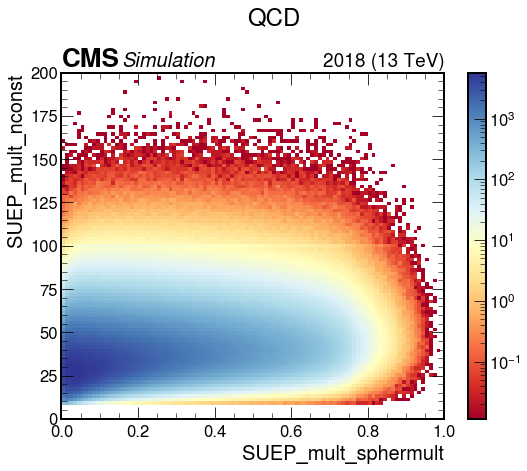

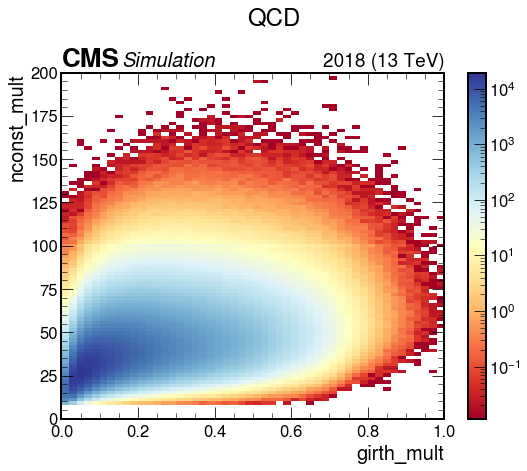

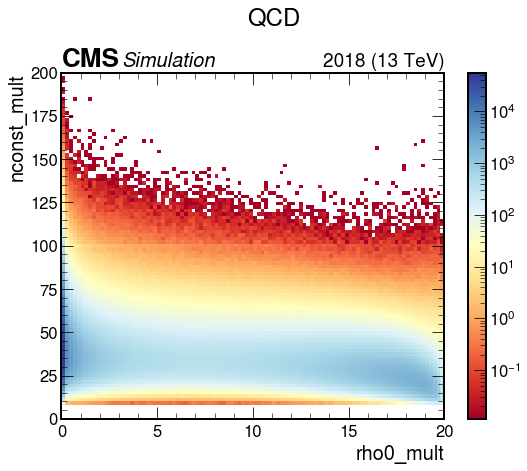

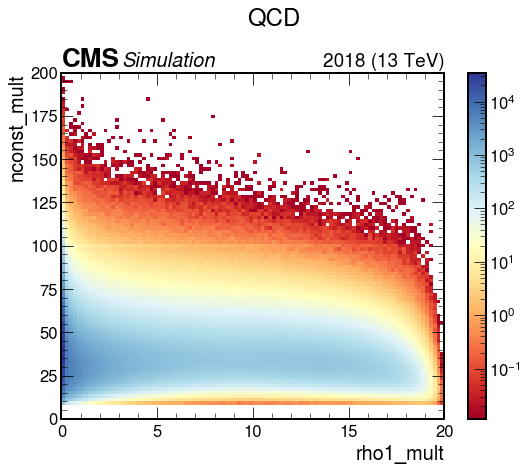

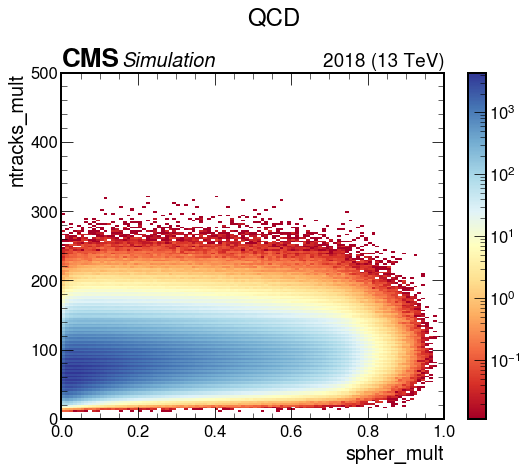

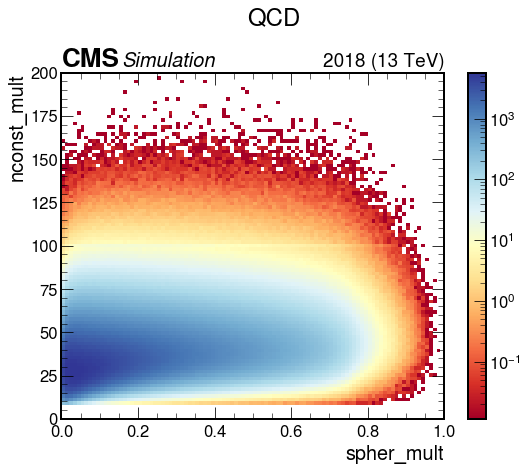

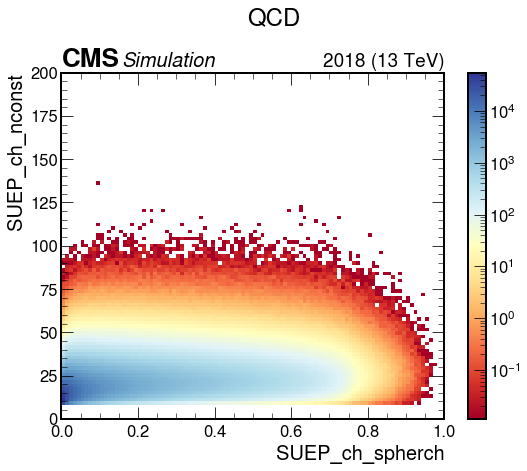

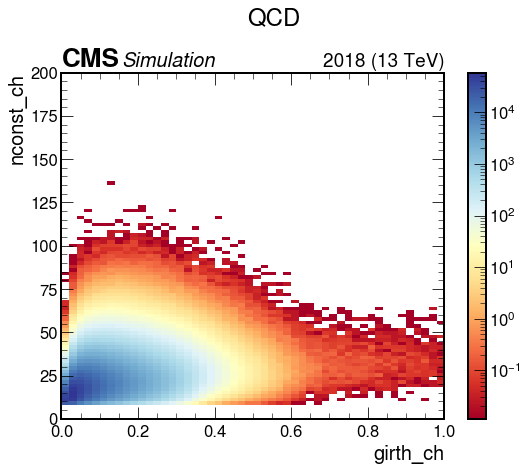

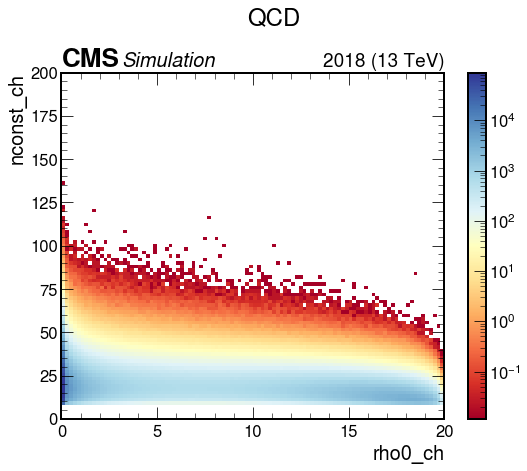

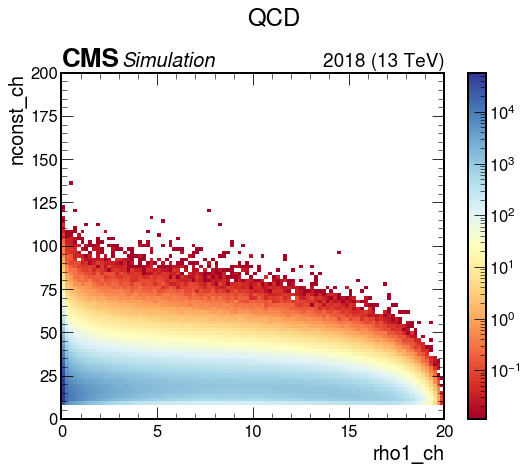

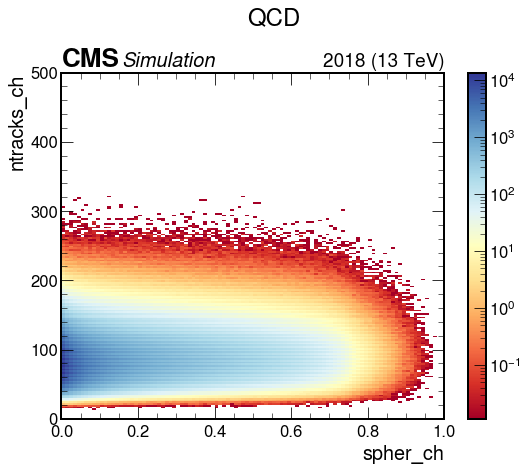

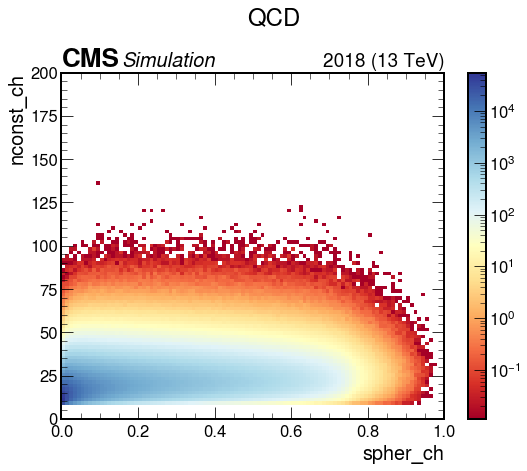

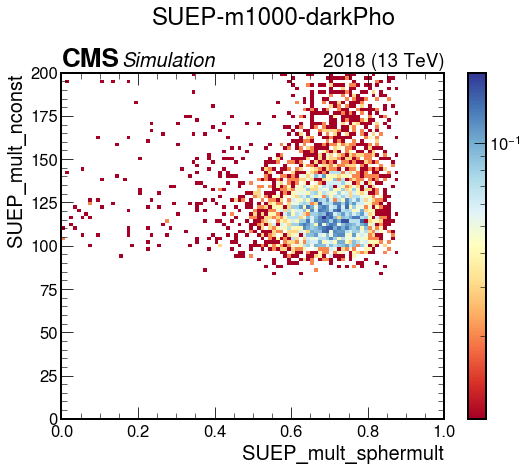

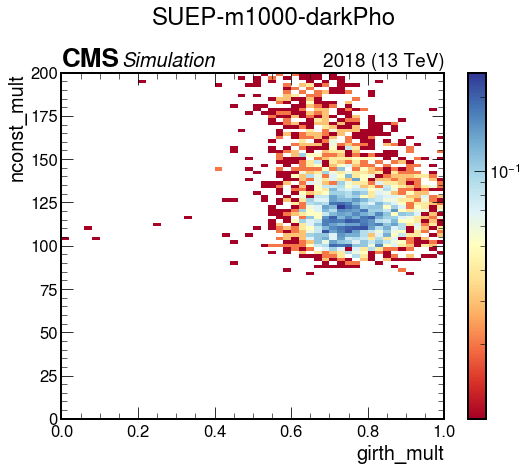

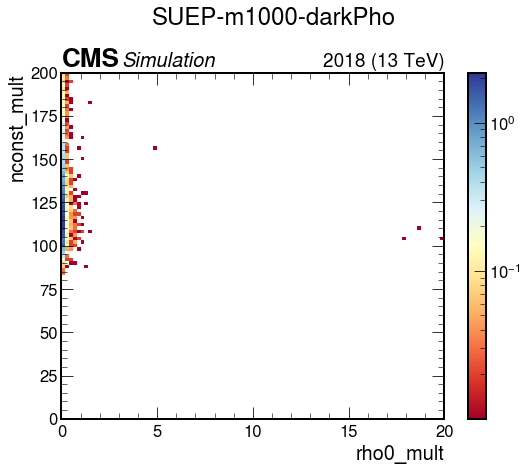

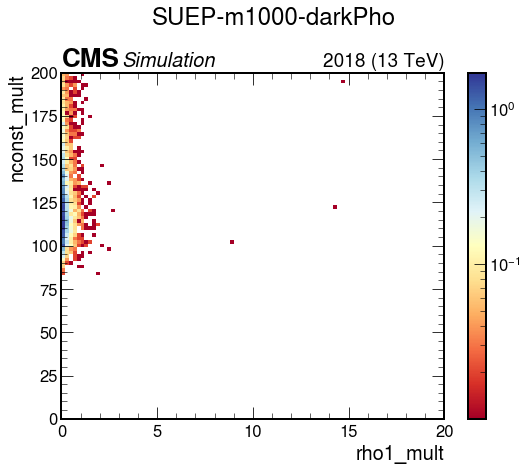

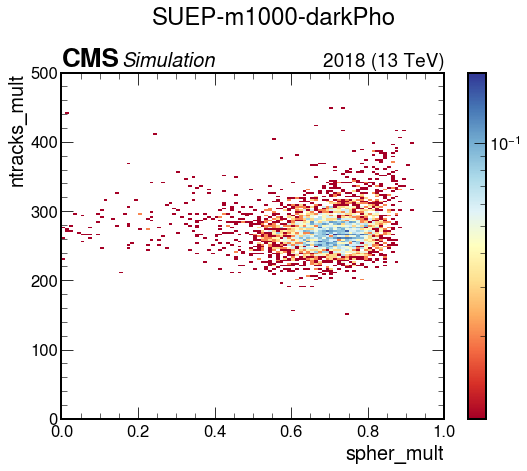

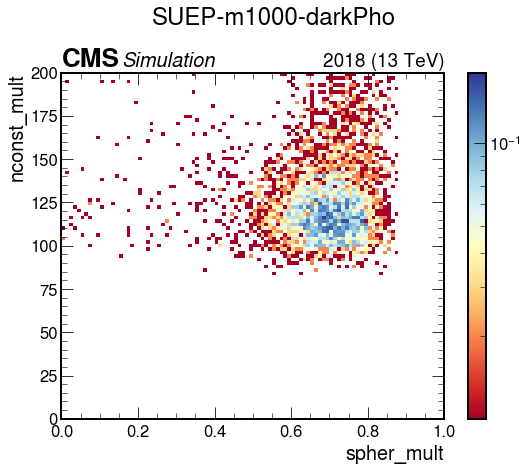

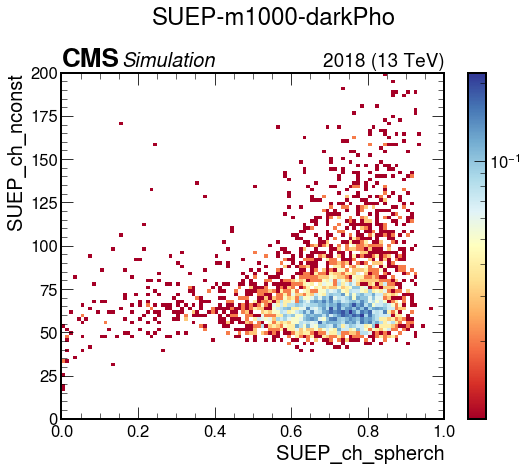

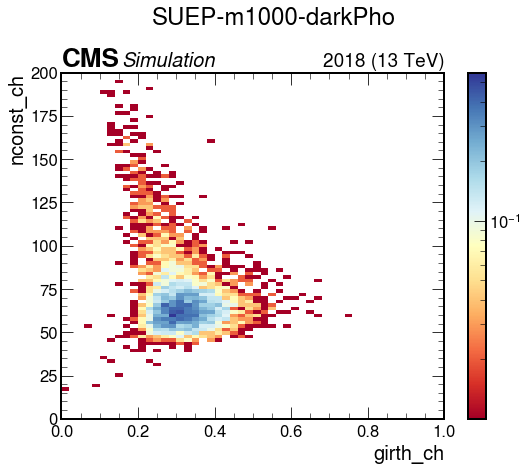

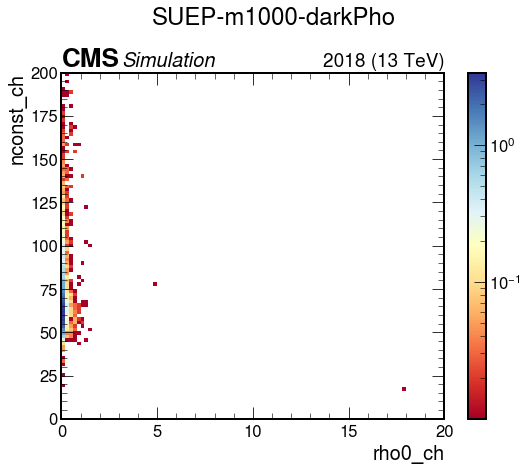

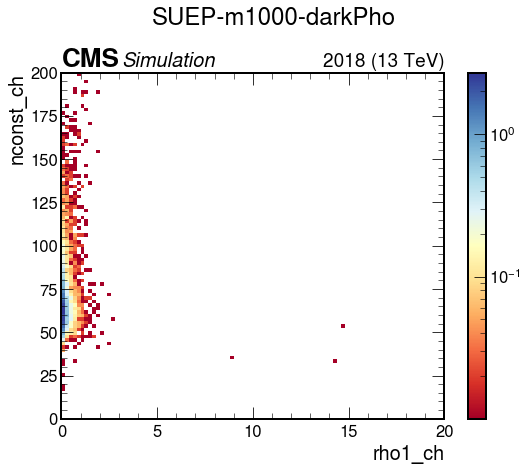

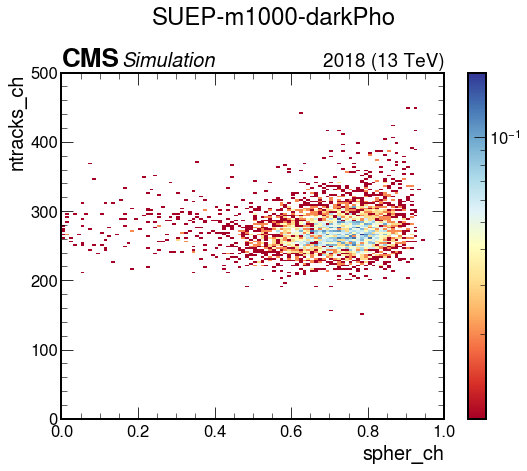

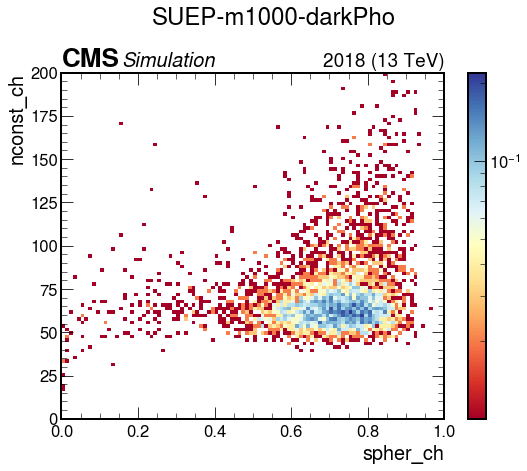

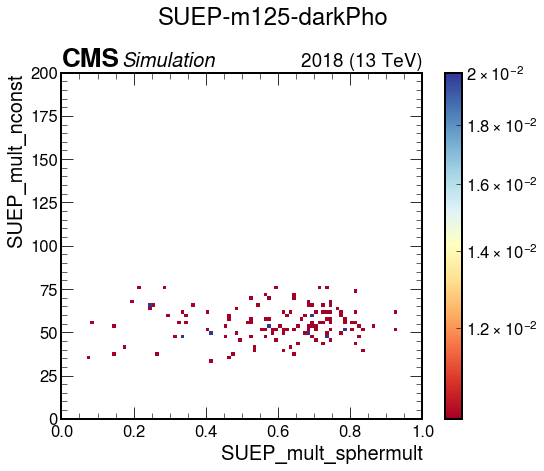

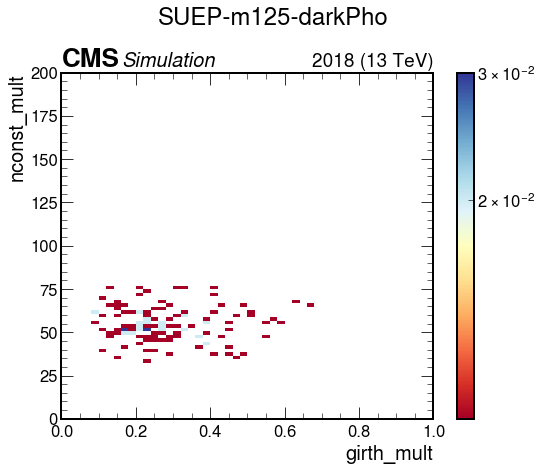

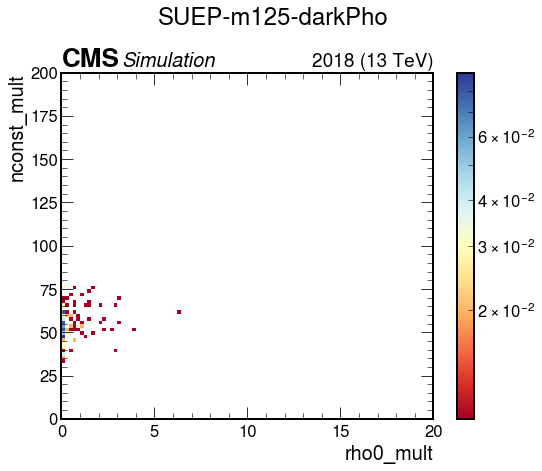

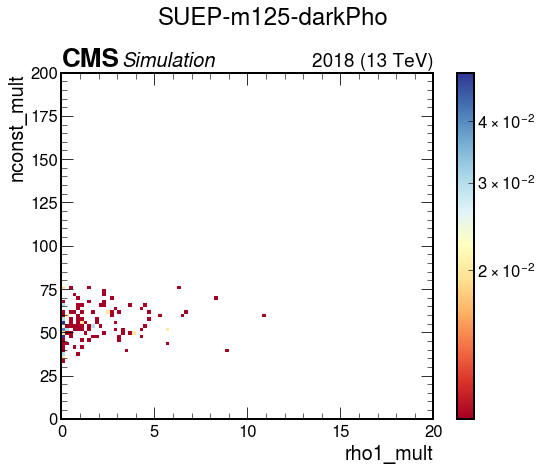

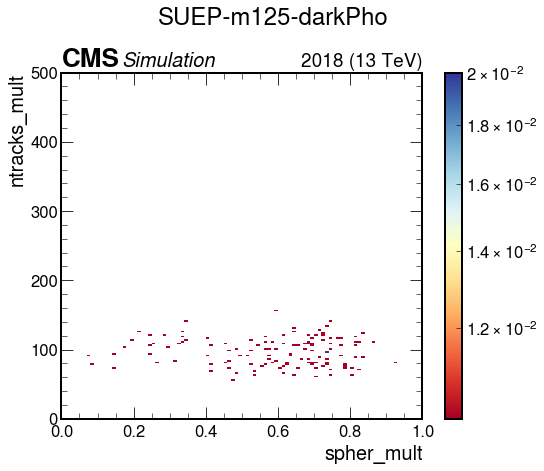

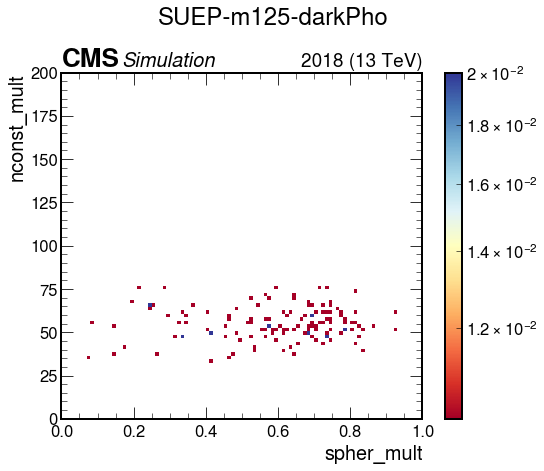

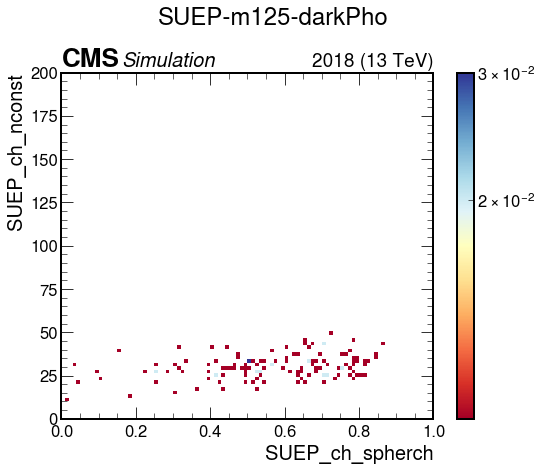

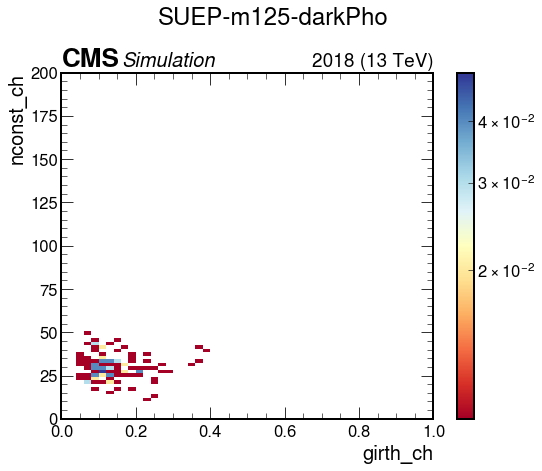

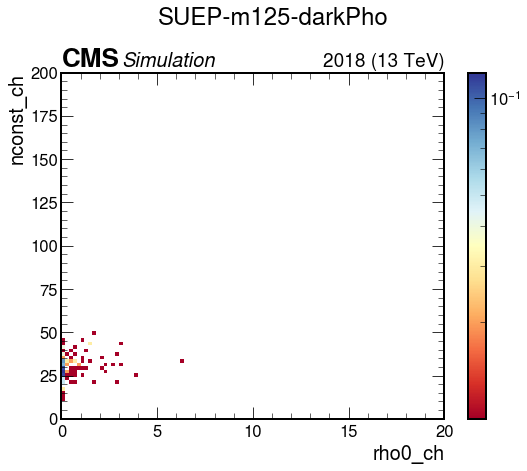

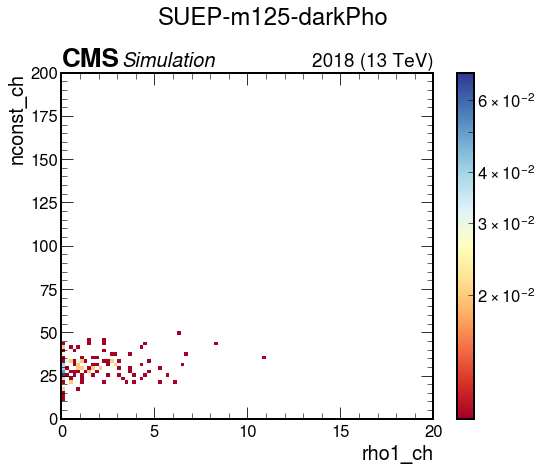

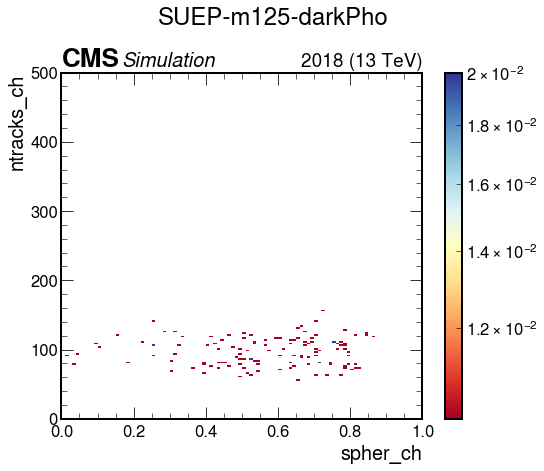

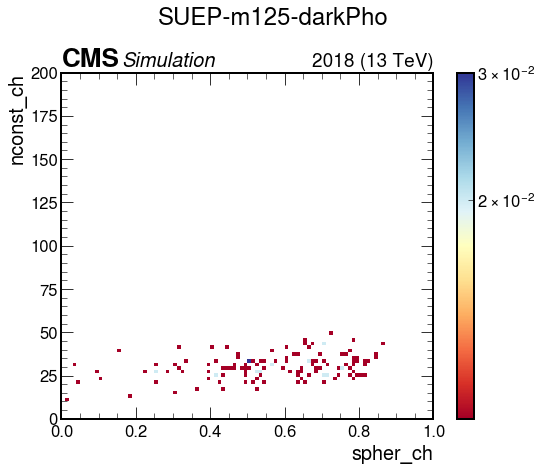

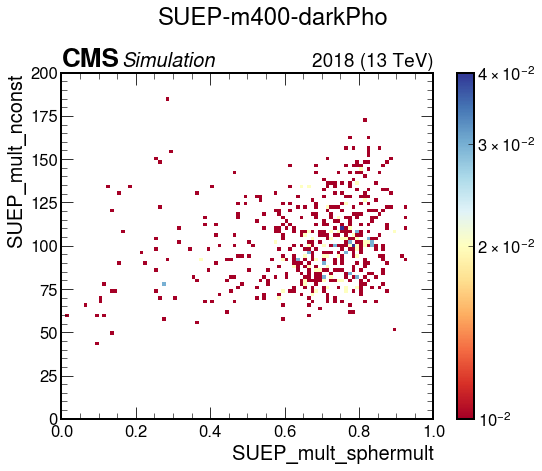

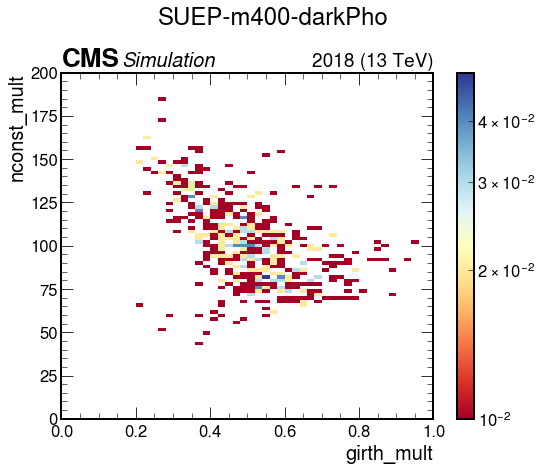

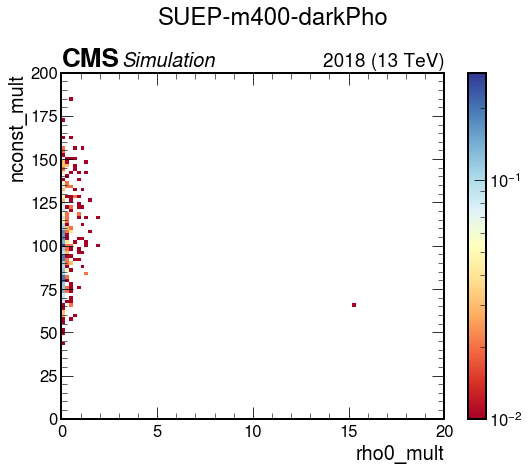

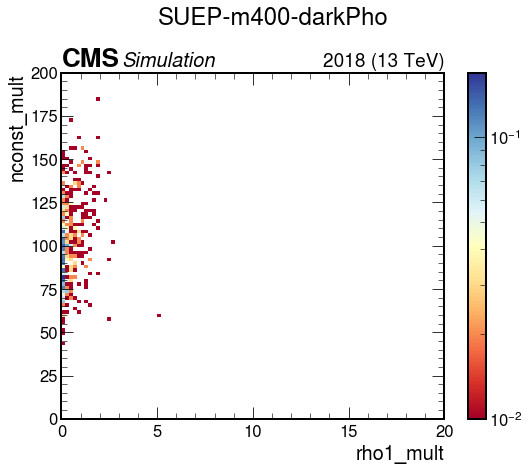

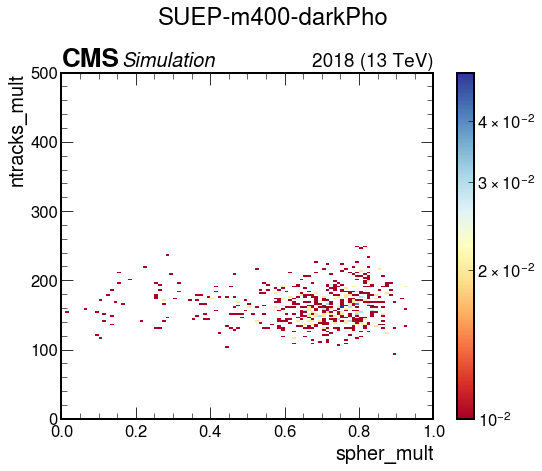

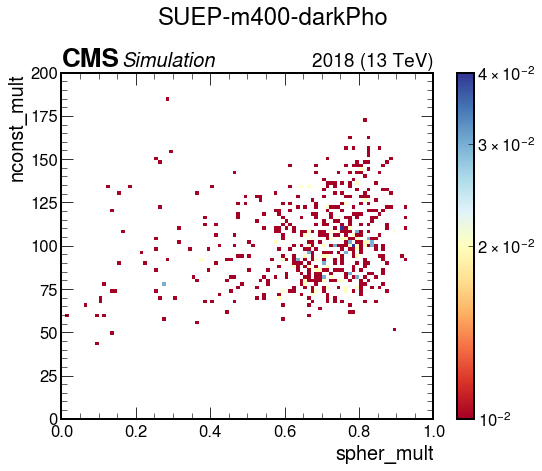

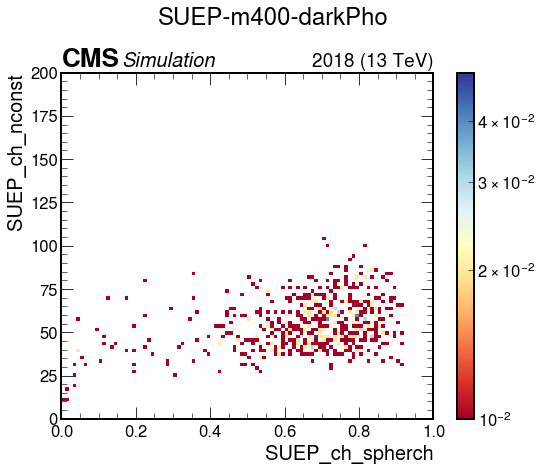

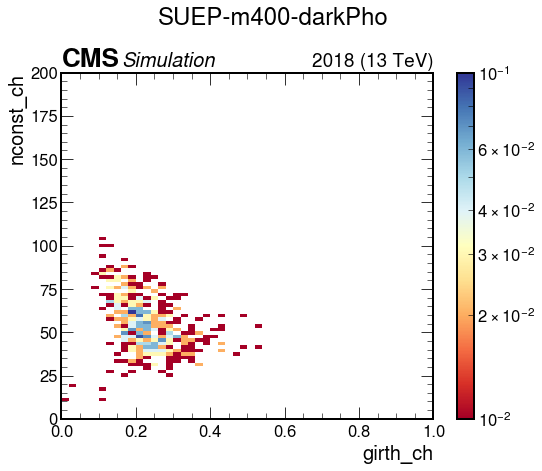

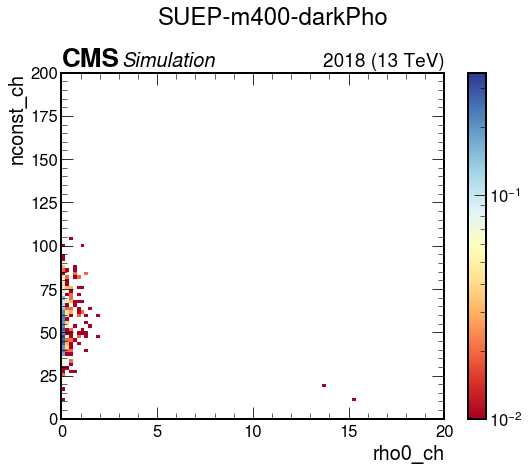

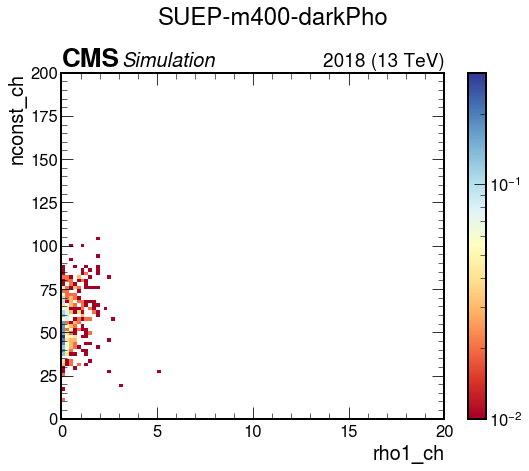

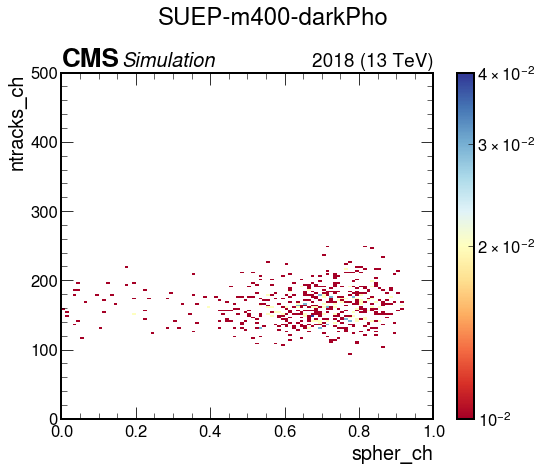

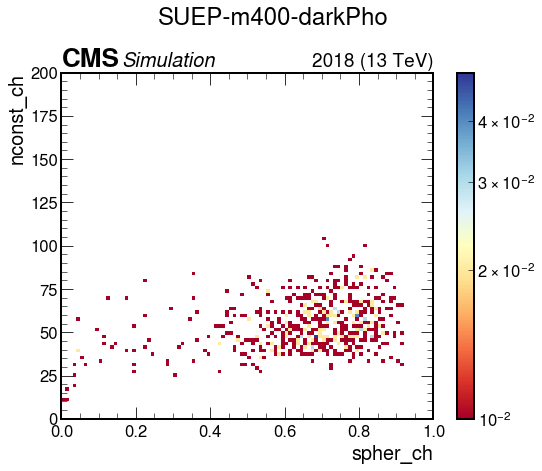

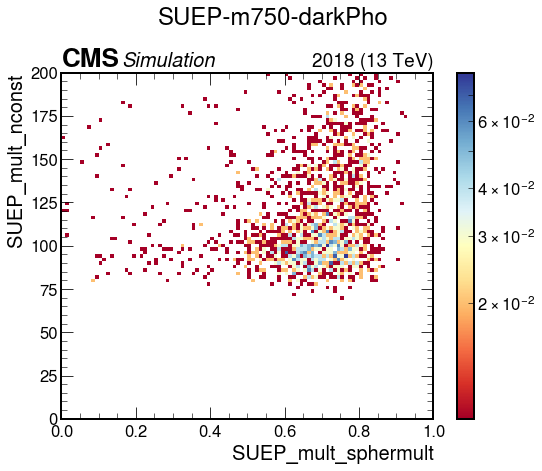

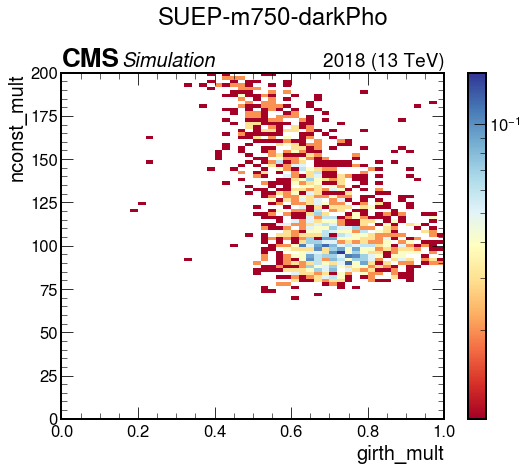

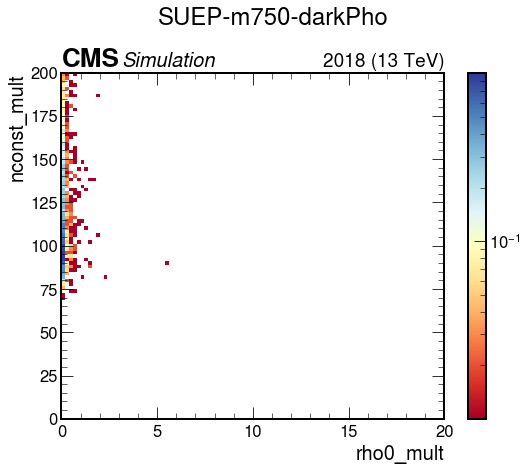

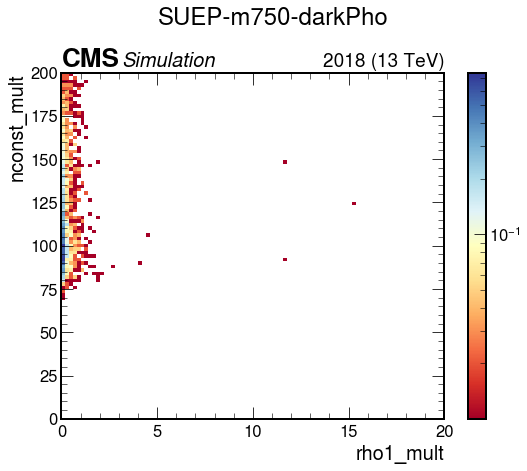

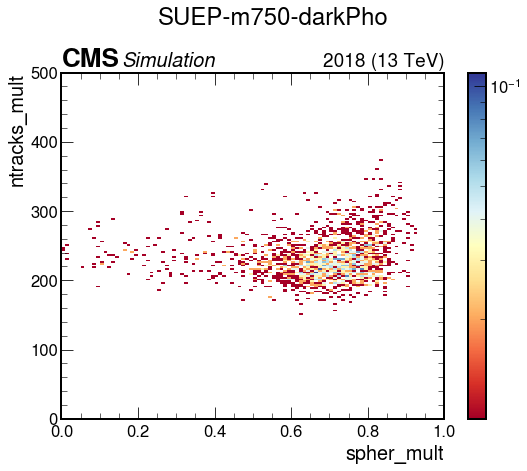

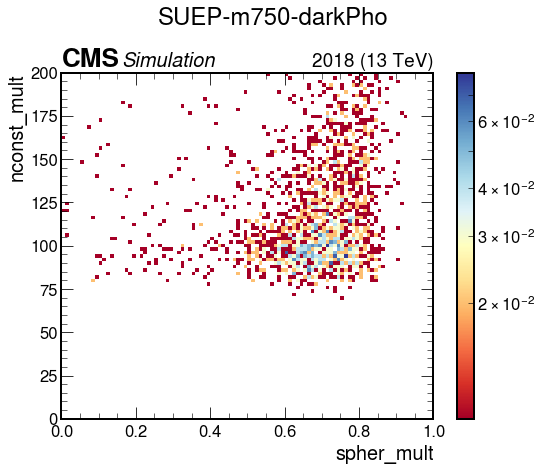

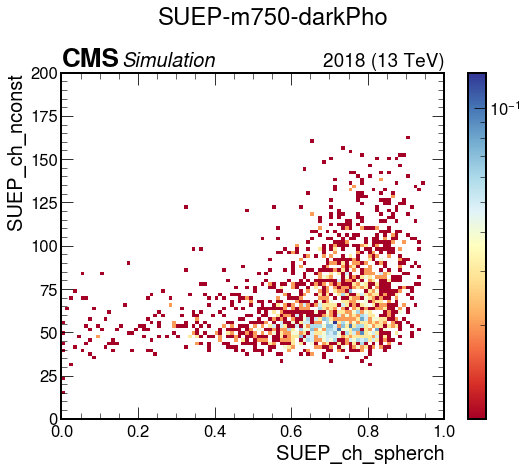

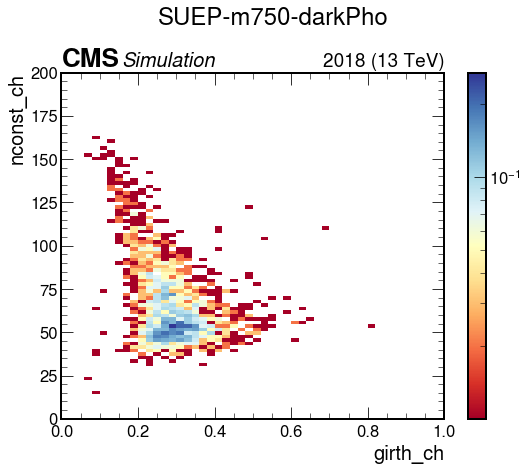

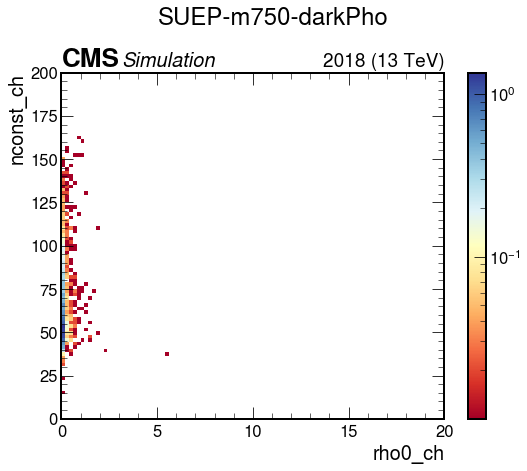

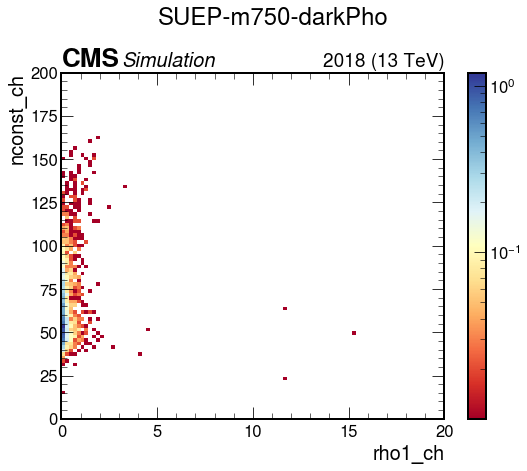

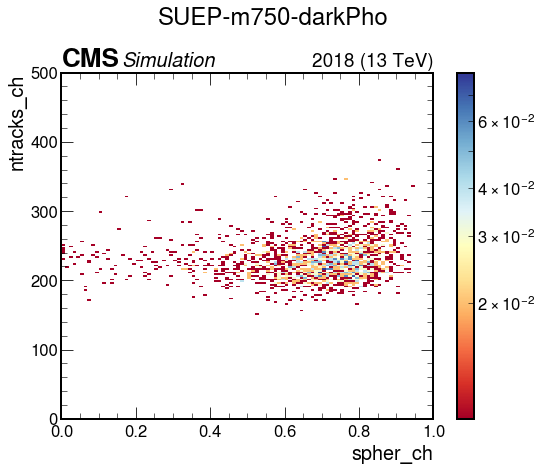

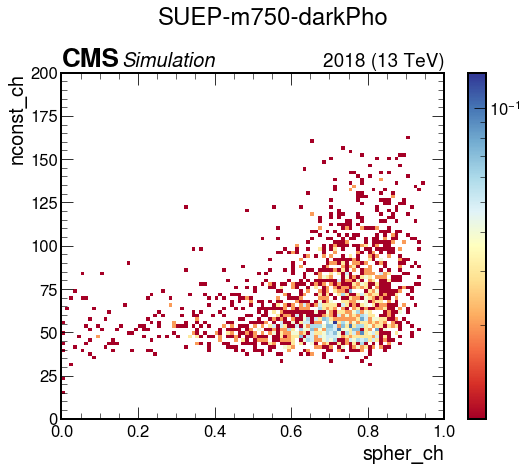

In [18]:
### 2D PLOTS
# makes the 2D plots from showlist

# datasets for 2D plots
datasets2d = ['QCD',
            "SUEP-m1000-darkPho+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m125-darkPho+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m400-darkPho+RunIIAutumn18-private+MINIAODSIM",
           "SUEP-m750-darkPho+RunIIAutumn18-private+MINIAODSIM"]

for dataset in datasets2d:
    for plot_label in showlist:
        if 'D_obs' in plot_label and (not unblind): continue
        if '2D' not in plot_label: continue
                
        save = plot_label in savelist

        # define figure, axis on which to plot QCD and SUEP
        fig, ax = plt.subplots(figsize=(8,7))
        hep.cms.label(data=False,year='2018', fontsize=20)

        if 'SUEP' in dataset: h = SUEP_plots[dataset][plot_label]
        elif 'QCD' in dataset and 'QCD' != dataset: h = QCD_plots[dataset][plot_label]
        elif 'QCD' == dataset: 
            for i,QCD_sample in enumerate(QCD_plots.keys()):
                if i==0: 
                    h = QCD_plots[QCD_sample][plot_label]
                else: 
                    h = h + QCD_plots[QCD_sample][plot_label]
        if '+' in dataset:
            i = find_nth(dataset,'+',1)
            l = dataset[:i]
        else: l = dataset
        plot2d(h, ax, log=True)

        fig.suptitle(l, y=0.95)
        fig.tight_layout()
        fig.show()

        if save: fig.savefig(l + "_" + plot_label + file_ext, bbox_inches='tight')

/tmp/ipykernel_3346114/2163453859.py:37: RuntimeWarning: invalid value encountered in true_divide
  y_vals = y_vals / norm
/tmp/ipykernel_3346114/2163453859.py:38: RuntimeWarning: invalid value encountered in true_divide
  e_vals = np.sqrt(np.sum(errs[:,(y>val_lo) & (y<=val_up)],axis=1))/norm
/home/submit/lavezzo/miniconda3/envs/SUEP/lib/python3.9/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


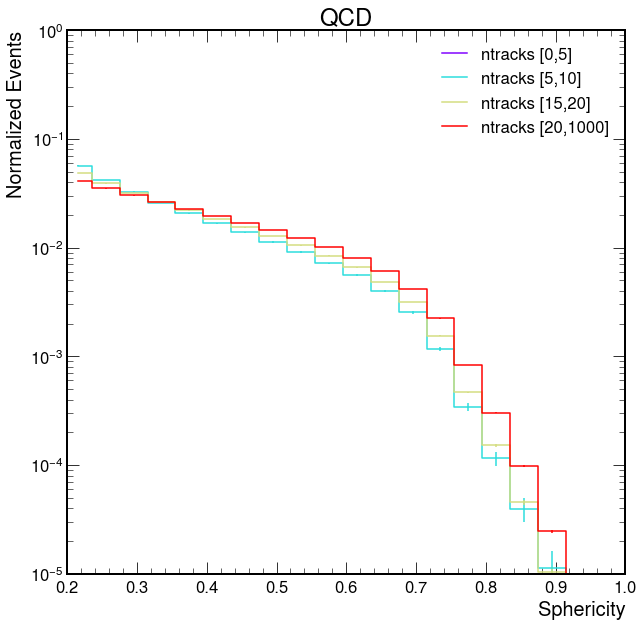

In [19]:
### 1D slices of a 2D plot for QCD

# parameters
plot_label = '2D_spher_nconst_ch'   # name of the plot to be sliced
slice_label = 'ntracks'              # variable being sliced, used in the plot legend
# bins of values to be sliced
# e.g. for equal slices use np.linspace(start, end, number of bins)
# if not can specify as [[0,10],[20,40],[40,50],...]
#slices = [[0,20],[20,40],[40,60],[60,80],[80,100],[100,1000]]      
slices = [[0,20],[20,40],[40,60],[60,1000]]


cmap = plt.cm.rainbow(np.linspace(0, 1, len(slices)))
for i,QCD_sample in enumerate(QCD_plots.keys()):
    if i==0: h = QCD_plots[QCD_sample][plot_label]
    else: h = h + QCD_plots[QCD_sample][plot_label]

w, x, y =h.to_numpy()
errs = h.variances()
x=x[:-1]
y=y[:-1]

# cut below sphericity 0.2
sphericityCut = (x>=0.2)
x=x[sphericityCut]
w=w[sphericityCut,:]
errs = errs[sphericityCut,:]

for i in range(len(slices)):
    val_lo = slices[i][0]
    val_up = slices[i][1]
    
    x_vals = x
    y_vals = np.sum(w[:,(y>val_lo) & (y<=val_up)],axis=1)
    norm = np.sum(y_vals) 
    y_vals = y_vals / norm
    e_vals = np.sqrt(np.sum(errs[:,(y>val_lo) & (y<=val_up)],axis=1))/norm
    
    ### FIXME: could be made a parameter
    # where you can define which slices you want to rebin
    if True:
        x_vals, y_vals, e_vals = combine_bins(x_vals, y_vals, e_vals, 4)
        
    plt.errorbar(x_vals, y_vals, e_vals, linestyle='', color=cmap[i])
    plt.step(x_vals, y_vals, label=slice_label+" [{0},{1}]".format(val_lo, val_up), where='mid', color=cmap[i])

plt.legend()
plt.title("QCD")
plt.xlim(0.2,1.0)
plt.ylim(1e-5,1)
plt.yscale('log')
plt.ylabel("Normalized Events")
plt.xlabel("Sphericity")
plt.savefig(plot_label+'_1D_slices'+file_ext)

/tmp/ipykernel_3346114/630878632.py:64: RuntimeWarning: divide by zero encountered in true_divide
  yerrors = [Dobs/Dexp - (Dobs-hQCD_Dobs_errs)/(Dexp+hQCD_Dexp_errs),(Dobs+hQCD_Dobs_errs)/(Dexp-hQCD_Dexp_errs) - Dobs/Dexp]
/tmp/ipykernel_3346114/630878632.py:64: RuntimeWarning: invalid value encountered in true_divide
  yerrors = [Dobs/Dexp - (Dobs-hQCD_Dobs_errs)/(Dexp+hQCD_Dexp_errs),(Dobs+hQCD_Dobs_errs)/(Dexp-hQCD_Dexp_errs) - Dobs/Dexp]
/tmp/ipykernel_3346114/630878632.py:64: RuntimeWarning: invalid value encountered in subtract
  yerrors = [Dobs/Dexp - (Dobs-hQCD_Dobs_errs)/(Dexp+hQCD_Dexp_errs),(Dobs+hQCD_Dobs_errs)/(Dexp-hQCD_Dexp_errs) - Dobs/Dexp]
/tmp/ipykernel_3346114/630878632.py:66: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(x[:-1],np.where(Dobs>0,Dobs/Dexp,1),yerr=yerrors, color="black", fmt='o')
/tmp/ipykernel_3346114/630878632.py:66: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x[:-1],np.where(Dobs>0,Dobs/Dexp,1

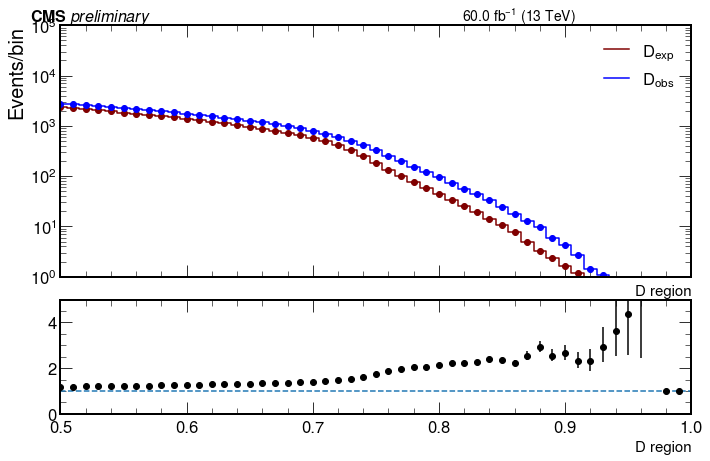

In [20]:
### Make D closure plot based on selection (e.g. 'ch', 'mult')
selection = 'ch'

# combine the QCD hists
for i,QCD_sample in enumerate(QCD_plots.keys()):
    if i==0: 
        hQCD_Dexp = QCD_plots[QCD_sample]['D_exp_'+selection]
        hQCD_Dexp_errs = QCD_plots[QCD_sample]['D_exp_'+selection].variances()
        hQCD_Dobs = QCD_plots[QCD_sample]['D_obs_'+selection]
        hQCD_Dobs_errs = QCD_plots[QCD_sample]['D_obs_'+selection].variances()
    else: 
        hQCD_Dexp = hQCD_Dexp + QCD_plots[QCD_sample]['D_exp_'+selection]
        hQCD_Dexp_errs = hQCD_Dexp_errs + QCD_plots[QCD_sample]['D_exp_'+selection].variances()
        hQCD_Dobs = hQCD_Dobs + QCD_plots[QCD_sample]['D_obs_'+selection]
        hQCD_Dobs_errs = hQCD_Dobs_errs + QCD_plots[QCD_sample]['D_obs_'+selection].variances()
        
hQCD_Dobs_errs = np.sqrt(hQCD_Dobs_errs)
hQCD_Dexp_errs = np.sqrt(hQCD_Dexp_errs)

#Set up variables for the stacked histogram
plt.figure(figsize=(12,10))
plt.gcf().subplots_adjust(bottom=0.15, left=0.17)
ax1 = plt.subplot2grid((4,1), (0,0),rowspan=2)

Dexp, x = hQCD_Dexp.to_numpy()
ax1.step(x[:-1],Dexp, color='maroon',label=r"$D_{exp}$", where='mid')
ax1.errorbar(x[:-1],Dexp, yerr=hQCD_Dexp_errs, color="maroon".upper(), fmt='o')

Dobs, x = hQCD_Dobs.to_numpy()
ax1.step(x[:-1],Dobs, color='blue',label=r"$D_{obs}$", where= 'mid')
ax1.errorbar(x[:-1],Dobs, yerr=hQCD_Dobs_errs, color="blue".upper(), fmt='o')

xmin = 0.5
ax1.set_yscale("log")
ax1.set_ylim([1e0, 1e5])
ax1.set_xlim([xmin,1.0])
    
#Set parameters that will be used to make the plots prettier
#max_y = ax1.gca().get_ylim()[1]
max_y = 1e5 + 1e4
max_x = max(x[:-1])
min_x = xmin
x_range = max_x - min_x
lower_label = min_x - x_range*0.05
upper_label = max_x - x_range*0.35
    
#X and Y labels (Do not use the central matplotlob default)
ax1.set_xlabel('D region', x=1, ha='right', fontsize=15)
ax1.set_ylabel("Events/bin", y=1, ha='right')
    
cms = ax1.text(
        lower_label, max_y*1.08, u"CMS $\it{preliminary}$",
        fontsize=16, fontweight='bold',
)

lumi = ax1.text(
        upper_label, max_y*1.08, r"%.1f fb$^{-1}$ (13 TeV)" % 60,
        fontsize=14, 
)
ax1.legend()

ax2 = plt.subplot2grid((4,1), (2,0),sharex=ax1)
plt.setp(ax1.get_xticklabels(), visible=False)
yerrors = [Dobs/Dexp - (Dobs-hQCD_Dobs_errs)/(Dexp+hQCD_Dexp_errs),(Dobs+hQCD_Dobs_errs)/(Dexp-hQCD_Dexp_errs) - Dobs/Dexp]
#yerrors = [(QCD_obs-QCD_obs_errors)/(QCD_exp+QCD_exp_errors),(QCD_obs+QCD_obs_errors)/(QCD_exp-QCD_exp_errors)]
ax2.errorbar(x[:-1],np.where(Dobs>0,Dobs/Dexp,1),yerr=yerrors, color="black", fmt='o')
ax2.axhline(1, ls="--")
ax2.set_ylim(0,5)
ax2.set_xlabel("D region", fontsize=15)
plt.savefig("Dregion_closure_"+selection+file_ext)

In [93]:
from collections import defaultdict

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
SUEPdata = nested_dict(3,float)
QCDdata = nested_dict(2,float)
QCDcounts = nested_dict(3,float)

NameError: name 'SUEPdata' is not defined

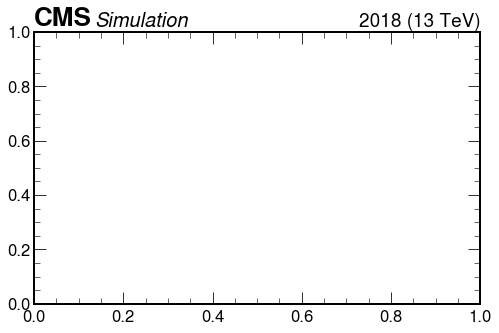

In [6]:
### Make ABCD plots and table based on selection (e.g. 'ch', 'mult')
selection = 'ch'
save = False

# only plot certain SUEP samples
darkPho = True
darkPhoHad = False
generic = False

SUEP_samples_toplot = []
for dataset in datasets:
    if darkPho and ('darkPho+' in dataset): SUEP_samples_toplot.append(dataset)
    if darkPhoHad and ('darkPhoHad+' in dataset): SUEP_samples_toplot.append(dataset)
    if generic and ('generic+' in dataset): SUEP_samples_toplot.append(dataset)

for plot_label in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
        
    if 'D_obs' in plot_label and (not unblind): continue
    
    # define figure, axis on which to plot QCD and SUEP
    fig, ax = plt.subplots(figsize=(8,5))
    hep.cms.label(data=False,year='2018', fontsize=20)
    
    # keep the SUEP hists separate for each sample
    SUEP_hists,SUEP_labels = [],[]
    for sample in SUEP_samples_toplot:
        i = find_nth(sample,'+',1)
        SUEP_labels.append(sample[:i])
        SUEP_hists.append(SUEP_plots[sample][plot_label])
        
        SUEPdata[sample[:i]][plot_label]["value"] = np.sum(SUEP_plots[sample][plot_label].values())
        #SUEPdata[sample[:i]][plot_label]["err"] = np.sum(SUEP_plots[sample][plot_label].variances())
        SUEPdata[sample[:i]][plot_label]["err"] = np.sqrt(SUEPdata[sample[:i]][plot_label]["value"])
    
    # combine the QCD hists
    for i,QCD_sample in enumerate(QCD_plots.keys()):
        if i==0: hQCD = QCD_plots[QCD_sample][plot_label]
        else: hQCD = hQCD + QCD_plots[QCD_sample][plot_label]
        QCDcounts[plot_label][QCD_sample] = np.sum(QCD_plots[QCD_sample][plot_label].values())
    
    # plot QCD, SUEP
    for hSUEP, l in zip(SUEP_hists, SUEP_labels): plot1d(hSUEP, ax, l)
    plot1d(hQCD, ax, 'QCD')
    SUEPdata['QCD'][plot_label]["value"] = np.sum(hQCD.values())
    SUEPdata['QCD'][plot_label]["err"] = np.sum(np.sqrt(hQCD.variances()))
    
    if plot_label == 'D_obs_' + selection: ax.set_ylim(1e-2,1e5)
    ax.set_yscale('log')
    ax.legend(loc='best', fontsize=12, framealpha=1, facecolor='white', shadow=True)
    
    if save: fig.savefig(output_label + "_" + plot_label + file_ext, bbox_inches='tight')

fig.tight_layout()
fig.show()

In [96]:
# Calculate which percentage of the total number of events in each 
# ABCD region each HT bin makes up

for abcd_region in list(QCDcounts.keys()):
    print("ABCD Region:",abcd_region)
    tot = 0
    for ht_region, val in list(QCDcounts[abcd_region].items()): 
        tot += val
    print("\tTotal:\t\t",round(tot,2))
    for ht_region, val in list(QCDcounts[abcd_region].items()):
        ht_region = ht_region[4:]
        ht_region = ht_region[:ht_region.find("_")]
        print("\t",ht_region, "\t", round(val*1.0/tot * 100,2), "%")

ABCD Region: A_ch
	Total:		 2054404.29
	  	 100.0 %
ABCD Region: B_ch
	Total:		 644926.37
	  	 100.0 %
ABCD Region: C_ch
	Total:		 781359.92
	  	 100.0 %
ABCD Region: D_exp_ch
	Total:		 245287.46
	  	 100.0 %
ABCD Region: D_obs_ch
	Total:		 322881.84
	  	 100.0 %


In [97]:
table = []
for i in range(len(list(SUEPdata.keys()))):
    label = list(SUEPdata.keys())[i]
    line = []
    line.append(label)
    
    for r in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
        if 'QCD' in label:
            line.append("{:0.0f} ".format(SUEPdata[label][r]['value']) + r'$\pm$' + " {:0.0f}".format(SUEPdata[label][r]['err']))
        else:
            line.append("{:0.2f} ".format(SUEPdata[label][r]['value']) + r'$\pm$' + " {:0.2f}".format(SUEPdata[label][r]['err']))
        
    if 'QCD' in label:
        line.append(round((SUEPdata[label]['D_exp_'+selection]['value']-SUEPdata[label]['D_obs_'+selection]['value'])/SUEPdata[label]['D_exp_'+selection]['value'],2))
        line.append(0)
    else:
        line.append(0)
        line.append(SUEPdata[label]['D_obs_'+selection]['value']/math.sqrt(SUEPdata[label]['D_obs_'+selection]['value']+SUEPdata[label]['D_exp_'+selection]['value']+SUEPdata[label]['D_obs_'+selection]['err']+SUEPdata['QCD']['D_exp_'+selection]['err']))
    table.append(line)                                                         

In [98]:
t = tabulate(table,tablefmt ='latex',
               headers=['Process', 'A', 'B', 'C', 'D_{exp}', 'D_{obs}', 'D_{exp}-D_{obs}/D_{exp}', 'S/$\sqrt(S+B+\sigma_{S}+\sigma_{B}$)'])
with open('table.txt', 'w') as f:
    f.write(t)
t

'\\begin{tabular}{llllllrr}\n\\hline\n Process            & A                  & B                 & C                 & D\\_\\{exp\\}           & D\\_\\{obs\\}           &   D\\_\\{exp\\}-D\\_\\{obs\\}/D\\_\\{exp\\} &   S/\\$\\textbackslash{}sqrt(S+B+\\textbackslash{}sigma\\_\\{S\\}+\\textbackslash{}sigma\\_\\{B\\}\\$) \\\\\n\\hline\n SUEP-m1000-darkPho & 0.00 \\$\\textbackslash{}pm\\$ 0.00    & 0.00 \\$\\textbackslash{}pm\\$ 0.00   & 2.18 \\$\\textbackslash{}pm\\$ 1.48   & 0.00 \\$\\textbackslash{}pm\\$ 0.00   & 46.26 \\$\\textbackslash{}pm\\$ 6.80  &                      0    &                              1.19059   \\\\\n SUEP-m750-darkPho  & 0.00 \\$\\textbackslash{}pm\\$ 0.00    & 0.00 \\$\\textbackslash{}pm\\$ 0.00   & 1.57 \\$\\textbackslash{}pm\\$ 1.25   & 0.00 \\$\\textbackslash{}pm\\$ 0.00   & 19.48 \\$\\textbackslash{}pm\\$ 4.41  &                      0    &                              0.506162  \\\\\n SUEP-m400-darkPho  & 0.00 \\$\\textbackslash{}pm\\$ 0.00    & 0.00 \\$

In [99]:
def convert2LatexString(s):
    r = r'(\^\{\})'; s = re.sub(r, "^", s)
    s = re.sub(r'\\([\$\_\{\}\^])', r'\1', s)
    s = re.sub(r'(\\textbackslash{})', r'\\', s)
    return s

t = convert2LatexString(t)
with open('table.txt', 'w') as f:
    f.write(t)
t

'\\begin{tabular}{llllllrr}\n\\hline\n Process            & A                  & B                 & C                 & D_{exp}           & D_{obs}           &   D_{exp}-D_{obs}/D_{exp} &   S/$\\sqrt(S+B+\\sigma_{S}+\\sigma_{B}$) \\\\\n\\hline\n SUEP-m1000-darkPho & 0.00 $\\pm$ 0.00    & 0.00 $\\pm$ 0.00   & 2.18 $\\pm$ 1.48   & 0.00 $\\pm$ 0.00   & 46.26 $\\pm$ 6.80  &                      0    &                              1.19059   \\\\\n SUEP-m750-darkPho  & 0.00 $\\pm$ 0.00    & 0.00 $\\pm$ 0.00   & 1.57 $\\pm$ 1.25   & 0.00 $\\pm$ 0.00   & 19.48 $\\pm$ 4.41  &                      0    &                              0.506162  \\\\\n SUEP-m400-darkPho  & 0.00 $\\pm$ 0.00    & 0.00 $\\pm$ 0.00   & 0.45 $\\pm$ 0.67   & 0.00 $\\pm$ 0.00   & 4.87 $\\pm$ 2.21   &                      0    &                              0.127279  \\\\\n SUEP-m125-darkPho  & 0.07 $\\pm$ 0.26    & 0.10 $\\pm$ 0.32   & 0.29 $\\pm$ 0.54   & 0.41 $\\pm$ 0.64   & 0.78 $\\pm$ 0.88   &                      0 